# OneTwoTrip Contest EDA  
Вторая часть исследования признаков. Проверка [предположений](https://t.me/onetwotrip_contest/712) [Eugeny](https://github.com/hanander).  
Он предлагает проанализировать данные user'а с наибольшим количеством покупок.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
PATH_TO_DATA = '../data/'
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'onetwotrip_challenge_train.csv'))
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'onetwotrip_challenge_test.csv'))

Добавим новый полезный признак:

In [3]:
def new_features(df):
    df['ticket_price'] = df['field1'] / df['field15']
    
new_features(train)
new_features(test)

full = pd.concat([train, test], join='inner')

Создадим датфрейм с одним уникальным пользователем, у которого наибольшее количество покупок.  
Мы уже знаем, что field4 - это номер покупки для конкретного человека, так что отсортируем по этому признаку. Возможно это поможет нам заметить временные признаки.

In [4]:
i = train['field4'].argmax()
user_max_id = train['userid'][i]
user = train[train['userid'] == user_max_id]
user.drop(columns=['orderid', 'userid'], inplace=True)
user.sort_values(by=['field4'], inplace=True)

In [5]:
user.head()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,ticket_price
162877,0,-0.548937,6,6,1,1,0,1,1,0,0,14,8,5,-0.521242,1,1,1,2,2,3,1,16,8,1,1,12,3,0,2,1,1,1,0,0,0,0,0,0,0,0,-0.548937
125446,0,-0.161080,6,6,2,0,0,1,1,0,1,15,9,3,0.179090,1,1,1,2,1,3,1,16,8,1,1,4,2,0,2,1,1,1,0,0,0,0,0,0,0,0,-0.161080
39421,0,-0.626508,6,6,3,0,0,1,1,0,0,15,8,2,-0.661308,1,1,1,2,2,3,1,17,20,1,1,12,3,0,2,1,1,1,0,1,0,0,0,0,0,0,-0.626508
174386,16,-0.005937,6,6,4,0,0,1,1,0,1,10,4,2,0.319156,1,4,1,4,2,1,1,1,7,1,1,12,3,0,2,1,0,0,1,1,0,0,0,0,0,0,-0.005937
83155,0,-0.083509,6,6,5,0,0,1,1,0,1,10,9,3,0.319156,1,5,1,4,2,2,1,16,18,1,1,12,3,0,2,1,1,1,1,0,0,0,0,0,0,1,-0.083509


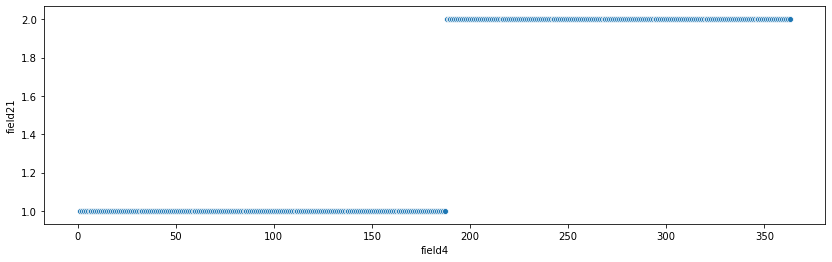

In [6]:
fig, ax = plt.subplots(figsize=(14, 4))

sns.scatterplot(x='field4', y='field21', data=user, ax=ax);

# Field2, Field3
Оба этих признака обозначают номер месяца. Но мы пока все еще не знаем, каким событиям соответствуют field2 и field3. Попробуем с этим разобраться. 
Для начала построим для этих признаков графики зависимости от field4.

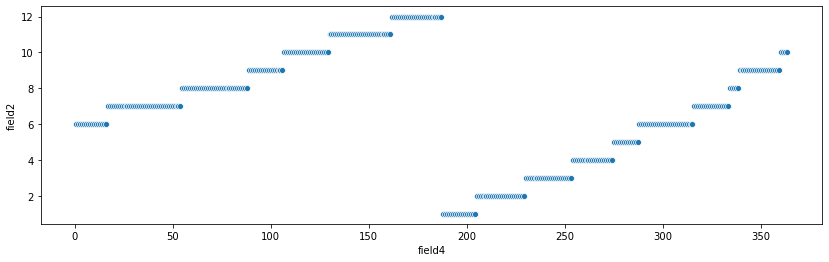

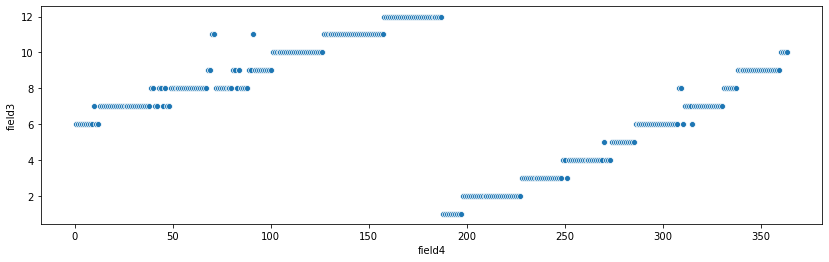

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.scatterplot(x='field4', y='field2', data=user, ax=ax);

fig, ax = plt.subplots(figsize=(14, 4))
sns.scatterplot(x='field4', y='field3', data=user, ax=ax);

- Графики довольно сильно похожи.  
- В данных есть два года.  
- field2 монотонно возрастает вместе с номером покупки, так что возникает предположение, что field2 означает месяц покупки.  

Проверим, есть ли в признаках индикатор года.  

Для этого найдем максимальный индекс field4 со значением 12 и разделим по нему (из графиков видно, что второй год не доходит до декабря).  И выведем корреляцию с получившимся признаком. 

Так как мы пока не знаем для какой даты может быть год, то нам нужно проверить и для field2, и для field3.

In [10]:
def ind_year(df, column):
    i = np.max(df[df[column] == 12]['field4'])
    df['year'] = (df['field4'] > i).astype(int) + 1
    return df.corr()[['year']].sort_values(by='year').transpose()

ind_year(user, 'field2')

,field29,field3,field2,indicator_goal23,indicator_goal24,field26,field12,indicator_goal25,field7,field14,ticket_price,goal22,field25,field22,field1,field10,goal1,field16,field13,field6,field27,field28,goal24,field18,field5,field9,field20,field17,field23,field11,indicator_goal22,field15,field24,field8,field0,field19,field4,field21,year,indicator_goal21,goal21,goal23,goal25
year,-0.693505,-0.685472,-0.675764,-0.338035,-0.275595,-0.243592,-0.209071,-0.189881,-0.17372,-0.160992,-0.145303,-0.136773,-0.134892,-0.133538,-0.112336,-0.107571,-0.09593,-0.094066,-0.091323,-0.087504,-0.074527,-0.067358,-0.055873,-0.05302,-0.05099,-0.05099,-0.042283,-0.039705,-0.029273,0.043589,0.05099,0.057747,0.082192,0.102404,0.122693,0.246444,0.865631,1.0,1.0,NaN,NaN,NaN,NaN


Здорово.  
field21 - это индикатор года. Проверим на всякий случай для field3.

In [12]:
ind_year(user, 'field3')

,field29,field3,field2,indicator_goal23,indicator_goal24,field26,field12,indicator_goal25,field7,field14,ticket_price,goal22,field25,field22,field1,field10,goal1,field16,field13,field6,field27,field28,goal24,field18,field5,field9,field20,field17,field23,field11,indicator_goal22,field15,field24,field8,field0,field19,field4,field21,year,indicator_goal21,goal21,goal23,goal25
year,-0.693505,-0.685472,-0.675764,-0.338035,-0.275595,-0.243592,-0.209071,-0.189881,-0.17372,-0.160992,-0.145303,-0.136773,-0.134892,-0.133538,-0.112336,-0.107571,-0.09593,-0.094066,-0.091323,-0.087504,-0.074527,-0.067358,-0.055873,-0.05302,-0.05099,-0.05099,-0.042283,-0.039705,-0.029273,0.043589,0.05099,0.057747,0.082192,0.102404,0.122693,0.246444,0.865631,1.0,1.0,NaN,NaN,NaN,NaN


То же самое. Чтобы проверить, какому месяцу соответсвует этот год, найдем более подходящего пользователя.

field21 - индикатор года. 1 и 2 поменяли местами.  
Для данного пользователя 
Чтобы проверить какому месяцу соответсвует этот год, найдем подходящего пользователя.

In [13]:
user_id_list = full['userid'].value_counts().head(10).index

for user_id in user_id_list:
    user_i = full[full['userid'] == user_id]
    if sum(user_i['field3'] - user_i['field2'] < 0) > 0:
        print(user_id)
        break

88a595f6f7754f656b33cca2c6addcb9c659c30bad00656779378af80209912a


In [15]:
ind_year(user_i, 'field2')['field21']

year    1.0
Name: field21, dtype: float64

In [16]:
ind_year(user_i, 'field3')['field21']

year    0.940335
Name: field21, dtype: float64

field21 - это год, который соответствует field2.  
Теперь посмотрим на график зависимости field2 и field3.

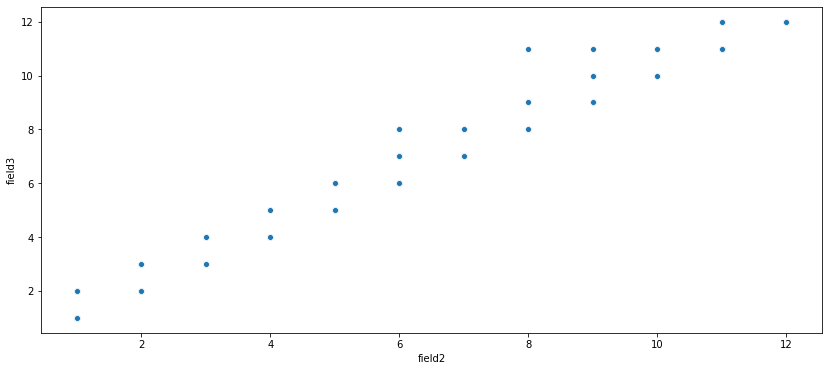

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(x='field2', y='field3', data=user, ax=ax);

field3 больше field2. Посмотрим на их разницу.

In [18]:
(user['field3'] - user['field2']).value_counts()

0    299
1     59
2      3
3      2
dtype: int64

Для всего датасета

In [19]:
(full['field3'] - full['field2']).value_counts()

 0     423561
 1     153506
 2      28826
-11     16064
 3       8244
-10      7471
-9       3954
 4       2332
-8       2097
-7       1305
-6        994
 5        844
-5        608
-4        390
 6        331
-3        273
 7        109
-2         99
-1         28
 8         21
 9         10
dtype: int64

Если отдельно рассмотреть последовательность положительных и последовательность отрицательных чисел, то можем заметить, что они возрастают. Давайте возьмем эту разницу по модулю 12. 

In [20]:
((full['field3'] - full['field2']) % 12).value_counts()

0     423561
1     169570
2      36297
3      12198
4       4429
5       2149
6       1325
7        717
8        411
9        283
10        99
11        28
dtype: int64

Очень похоже на то, что field3 следует после field2. Возможно, что field2 - это месяц покупки, а field3 - это месяц отлета.  
*На сайте можно брать билет максимум на 1 год вперед*

Добавим в full новый признак и посмотрим корреляцию.

In [21]:
full['diff_3_2'] = (full['field3'] - full['field2']) % 12
full.corr()[['diff_3_2']].sort_values(by='diff_3_2', ascending=False).transpose()

,diff_3_2,field16,field6,field1,ticket_price,field25,field7,field15,field24,field22,field14,field12,indicator_goal24,field17,field10,field28,indicator_goal23,field13,field5,field11,field20,field18,field9,field27,indicator_goal25,field2,orderid,field26,indicator_goal21,field0,field29,indicator_goal22,field4,field21,field23,field19,field3,field8
diff_3_2,1.0,0.919308,0.199917,0.185414,0.170077,0.165535,0.156476,0.138363,0.132071,0.129536,0.125315,0.121531,0.111225,0.074496,0.073585,0.071332,0.057593,0.053096,0.046839,0.036053,0.021875,0.015537,0.011426,0.010173,0.000055,-0.001295,-0.001606,-0.002835,-0.004014,-0.005471,-0.009674,-0.017051,-0.032209,-0.043639,-0.04938,-0.058975,-0.096089,-0.2066


field16 - 0.919308

Построим график зависимости нового признака и field16.

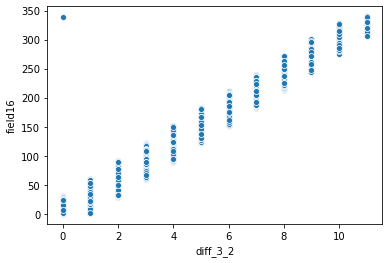

In [22]:
sns.scatterplot(x='diff_3_2', y='field16', data=full);

In [23]:
full[(full['diff_3_2'] == 0) & (full['field16'] > 100)]

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,ticket_price,diff_3_2
174053,174053,e19d6f8a56f3ce4d9e7a2a853d21401dabaa01d878ae22...,0,0.459491,9,9,1,1,0,2,1,0,1,17,43,1,0.17909,2,339,1,5,1,1,1,81,3,2,6,1,1,0,3,1,1,0,0,1,0.229745,0


Для дальнейшего анализа выбросим эту точку.

In [24]:
full_new = full[~((full['diff_3_2'] == 0) & (full['field16'] > 100))]

In [25]:
full_new.groupby(['diff_3_2'])[['field16']].agg(['min', 'max', 'mean', 'std'])

field16                            
             min  max        mean        std
diff_3_2                                    
0              0   31    4.912678   5.283534
1              1   61   20.933691  12.944115
2             29   91   56.205664  12.624537
3             60  122   87.117560  12.383766
4             90  151  118.245879  12.487656
5            122  182  148.941833  12.646603
6            152  211  179.227925  12.456728
7            183  239  208.270572  11.847701
8            213  271  239.019465  12.284617
9            244  301  269.568905  10.977638
10           276  328  298.626263  11.371811
11           307  340  326.714286   8.584470

Для min, max, mean шаг примерно 30.  
Почему для  min 0 и 1 нет такого шага? Рассмотрите пример: 31 января, 1 февраля.

Очевидно, что field16 - это количество дней между двумя датами. field2 и field3 - месяцы этих дат.
Если field2 - это месяц покупки, а field3 - это месяц вылета, то field16 - это количество дней между этими датами.

#  Field18, Field20
Кроме месяцев у нас есть предположительно дни недели.  
*Добавим функции из предыдущего ноутбука.*

In [26]:
def true_countplot(df, column):
    '''Строит график не количества покупок, а количество билетов для каждой категории.'''
    
    df_count = df.groupby([column])[['field15']].sum().reset_index()
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.barplot(x=column, y='field15', data=df_count);

def mean_price_plot(df, column):
    '''Строит график средних цен для каждой категории.'''
    
    df_price = df.groupby([column])[['ticket_price']].mean()
    df_price.reset_index(inplace=True)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.pointplot(x=column, y='ticket_price', data=df_price, ax=ax);

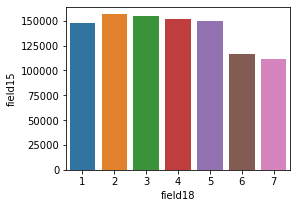

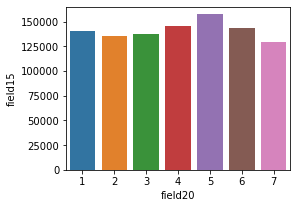

In [27]:
true_countplot(full, 'field18')
true_countplot(full, 'field20')

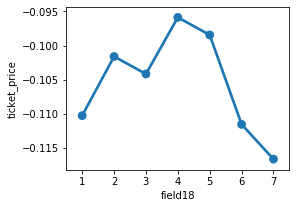

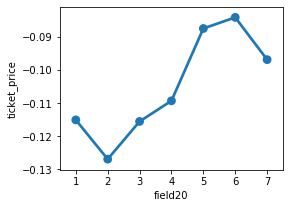

In [28]:
mean_price_plot(full, 'field18')
mean_price_plot(full, 'field20')

Судя по этим графикам field20 должен соответствовать дате вылета.


Давайте вернемся к пользователю с наибольшим количеством покупок.  
Возьмем только интересующие нас признаки и добавим к ним еще два новых:
- field16 (количество дней между двумя датами) по модулю 7
- разница между днями недели по модулю 7  

Если дни недели соответствуют тем же датам, то эти два новых признака должны быть равны.

In [29]:
user_date = user[['field2', 'field3', 'field18', 'field20', 'field16']]
user_date['diff_20_18'] = (user_date['field20'] - user_date['field18']) % 7
user_date['field16_mod_7'] = user_date['field16'] % 7
user_date.head(15)

,field2,field3,field18,field20,field16,diff_20_18,field16_mod_7
162877,6,6,2,3,1,1,1
125446,6,6,2,3,1,1,1
39421,6,6,2,3,1,1,1
174386,6,6,4,1,4,4,4
83155,6,6,4,2,5,5,5
186621,6,6,5,3,5,5,5
102930,6,6,5,6,8,1,1
189031,6,6,1,4,3,3,3
177676,6,6,1,5,4,4,4
74136,6,7,1,2,8,1,1


Это очень здорово. 
То есть
- field18 и field2 - день недели и месяц первой даты (скорее всего это покупка билета).  
- field20 и field3 - это день недели и месяц второй даты (скорее всего вылет).

Давайте проверим нет ли каких-то ошибок.

In [30]:
user_date[user_date['diff_20_18'] != user_date['field16_mod_7']]

,field2,field3,field18,field20,field16,diff_20_18,field16_mod_7
65721,8,8,3,5,3,2,3


Странно. А для всего датасета?

In [31]:
full['diff_20_18'] = (full['field20'] - full['field18']) % 7
full['field16_mod_7'] = full['field16'] % 7
sum(full['diff_20_18'] != full['field16_mod_7'])

31643

Посмотрим, на сколько эти две величины отличаются. 

In [32]:
(full['diff_20_18'] - full['field16_mod_7']).value_counts()

 0    619424
-1     28945
 6      2698
dtype: int64

То есть +- 1.  
5% - достаточно много. Мб какие-то из этих данных для дат по-разному считаются?

In [35]:
full_1 = full[full['field16'] == 4]
full_1 = full.copy()

df1 = full_1[full_1['diff_20_18'] == full_1['field16_mod_7'] - 1]
df2 = full_1[full_1['diff_20_18'] == full_1['field16_mod_7'] + 6]
df3 = full_1[full_1['diff_20_18'] == full_1['field16_mod_7']]

a = ((df1['field23'] - df1['field11'])).value_counts()
b = ((df2['field23'] - df2['field11'])).value_counts()
c = ((df3['field23'] - df3['field11'])).value_counts()

pd.DataFrame([a, b, c], index=['-1', '+1', '0'])

,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,223.0,484.0,381.0,315.0,495.0,659.0,1176.0,1414.0,1580.0,1576.0,1512.0,1636.0,1538.0,1528.0,1405.0,1427.0,1462.0,1499.0,1436.0,1379.0,1405.0,1449.0,1142.0,982.0,775.0
+1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,25.0,52.0,39.0,26.0,49.0,53.0,106.0,118.0,162.0,155.0,160.0,154.0,146.0,142.0,134.0,126.0,119.0,145.0,130.0,100.0,154.0,146.0,103.0,86.0,62.0
0,626.0,1359.0,2061.0,2539.0,2915.0,3817.0,5441.0,7664.0,10092.0,12117.0,14682.0,16512.0,18743.0,20320.0,21959.0,23144.0,24742.0,26183.0,27394.0,28531.0,29305.0,29362.0,28776.0,28029.0,26146.0,26721.0,27001.0,24790.0,22863.0,20336.0,18332.0,16017.0,13453.0,10960.0,8867.0,6339.0,4339.0,2862.0,1652.0,1037.0,691.0,361.0,208.0,136.0,NaN,NaN,NaN


# Field0
Eugeny предположил, что этот признак может быть количеством дней с предыдущей покупки. Проверим это.  
Для этого создадим накопительный признак, который будет собирать в себя field0. Возьмем его по модулю 7 и добавим 1 (потому что признаки дней недели у нас от 1 до 7)

In [36]:
user_date = user[['field18', 'field20', 'field0']]
user_date['cumsum0'] = np.cumsum(user_date['field0']) % 7 + 1
user_date.head(15)

,field18,field20,field0,cumsum0
162877,2,3,0,1
125446,2,3,0,1
39421,2,3,0,1
174386,4,1,16,3
83155,4,2,0,3
186621,5,3,1,4
102930,5,6,0,4
189031,1,4,3,7
177676,1,5,0,7
74136,1,2,0,7


field18 и cumsum0 отличаются на сдвиг 1. Добавим этот сдвиг и проверим.

In [37]:
user_date['cumsum0'] = (np.cumsum(user_date['field0']) + 1) % 7 + 1
user_date.head(15)

,field18,field20,field0,cumsum0
162877,2,3,0,2
125446,2,3,0,2
39421,2,3,0,2
174386,4,1,16,4
83155,4,2,0,4
186621,5,3,1,5
102930,5,6,0,5
189031,1,4,3,1
177676,1,5,0,1
74136,1,2,0,1


In [38]:
user_date.corr()

,field18,field20,field0,cumsum0
field18,1.000000,-0.048725,0.058079,1.000000
field20,-0.048725,1.000000,-0.083178,-0.048725
field0,0.058079,-0.083178,1.000000,0.058079
cumsum0,1.000000,-0.048725,0.058079,1.000000


Мое почтение [Eugeny](https://github.com/hanander) за этот признак. Я бы не заметил.

# Выводы:
- field2 - месяц покупки билетов, field4 (номер покупки) соответсвует месяцу покупки билета
- field3 - месяц вылета
- field16 - количество дней с момента покупки до момента вылета
- field21 - это год покупки
- field18 - день недели покупки
- field20 - день недели вылета
- field0 - количество дней прошедших с предыдущей покупки